In [2]:
import os, random
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import scipy.io as sio
from scipy.signal import butter, sosfiltfilt, lfilter, welch, filtfilt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

import mne
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scipy.stats import entropy
from tensorflow.keras.layers import Input   # Needed for CNN+LSTM

import tensorflow.keras.backend as K



SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


Step 1-3: Data Acquisition & Splitting

In [3]:
folder1 = Path(r"C:\Users\Cyan\Desktop\DataScience_Notes\DataScience_Capstone\EEG Data")
folder2 = Path(r"C:\Users\Cyan\Desktop\DataScience_Notes\DataScience_Capstone\eeg-during-mental-arithmetic-tasks-1.0.0")

all_files = [str(f) for f in folder1.glob("*.mat")] + [str(f) for f in folder1.glob("*.edf")]
all_files += [str(f) for f in folder2.glob("*.mat")] + [str(f) for f in folder2.glob("*.edf")]

random.shuffle(all_files)
n_total = len(all_files)
train_pct, val_pct, test_pct = 0.70, 0.15, 0.15
n_train, n_val = int(train_pct*n_total), int(val_pct*n_total)
train_files, val_files, test_files = all_files[:n_train], all_files[n_train:n_train+n_val], all_files[n_train+n_val:]


STEP 4: Preprocessing

In [4]:
def bandpass_filter(signal, sf, low=1, high=50, order=4):
    sos = butter(order, [low, high], btype='band', fs=sf, output='sos')
    return sosfiltfilt(sos, signal)

def segment_signal(signal, sf, window_sec=2, step_sec=None):
    if step_sec is None: step_sec = window_sec
    epoch_len, step = int(window_sec*sf), int(step_sec*sf)
    return [signal[i:i+epoch_len] for i in range(0, len(signal)-epoch_len+1, step)]

def normalize_epoch(epoch):
    return StandardScaler().fit_transform(epoch.reshape(-1,1)).flatten()


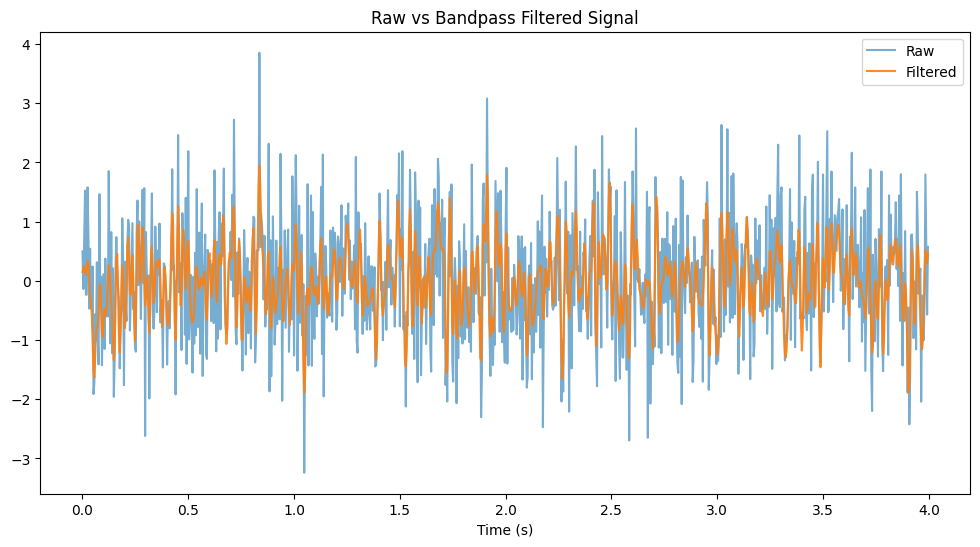

In [5]:
# Raw vs filtered signal
ch = np.random.randn(5000)  # placeholder signal
sf = 250
ch_filtered = bandpass_filter(ch, sf)
t = np.arange(len(ch[:1000]))/sf

plt.figure(figsize=(12,6))
plt.plot(t, ch[:1000], label="Raw", alpha=0.6)
plt.plot(t, ch_filtered[:1000], label="Filtered", alpha=0.9)
plt.title("Raw vs Bandpass Filtered Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.show()


STEP 5: Feature Extraction

In [75]:
def bandpower(epoch, sf, band):
    freqs, psd = welch(epoch, sf, nperseg=min(len(epoch), sf*2))
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return float(np.trapz(psd[idx], freqs[idx]))  

def hjorth_params(epoch):
    first_deriv, second_deriv = np.diff(epoch), np.diff(np.diff(epoch))
    activity = np.var(epoch)
    mobility = np.sqrt(np.var(first_deriv)/activity)
    complexity = np.sqrt(np.var(second_deriv)/np.var(first_deriv))/mobility
    return activity, mobility, complexity

def spectral_entropy(epoch, sf):
    freqs, psd = welch(epoch, sf)
    psd_norm = psd/np.sum(psd)
    return entropy(psd_norm)

feature_order = ["theta","alpha","beta","gamma","mean","var",
                 "hjorth_activity","hjorth_mobility","hjorth_complexity","spectral_entropy"]

feature_order = ["theta","alpha","beta","gamma","mean","var",
                 "hjorth_activity","hjorth_mobility","hjorth_complexity","spectral_entropy"]

def extract_features(epoch, sf, as_dict=True):
    hj_activity, hj_mobility, hj_complexity = hjorth_params(epoch)
    feats = {
        "theta": bandpower(epoch, sf, (4,7)),
        "alpha": bandpower(epoch, sf, (8,12)),
        "beta":  bandpower(epoch, sf, (13,30)),
        "gamma": bandpower(epoch, sf, (30,45)),
        "mean":  float(np.mean(epoch)),
        "var":   float(np.var(epoch)),
        "hjorth_activity": hj_activity,
        "hjorth_mobility": hj_mobility,
        "hjorth_complexity": hj_complexity,
        "spectral_entropy": spectral_entropy(epoch, sf)
    }
    if as_dict:
        return feats
    else:
        return [feats[k] for k in feature_order]  # list for ML



In [ ]:
epoch = np.random.randn(500)  # placeholder epoch
sf = 250
features = extract_features(epoch, sf)

plt.figure(figsize=(8,4))
plt.bar(feature_order, features, color="tab:orange")
plt.title("Extracted Features (Example Epoch)")
plt.xticks(rotation=45)
plt.show()


STEP 6: Rule-based Labeling

In [71]:
def compute_thresholds(X):
    X = np.array(X)
    return {
        "theta_high": np.percentile(X[:,0], 50),   # median
        "alpha_high": np.percentile(X[:,1], 50),
        "beta_high": np.percentile(X[:,2], 50),
        "gamma_high": np.percentile(X[:,3], 50),
    }

def map_condition_rule(features, thresholds):
    theta, alpha, beta, gamma = features[0], features[1], features[2], features[3]
    if beta > thresholds["beta_high"] and beta > alpha:
        return 0  # Focused
    if theta > thresholds["theta_high"] and theta > beta:
        return 1  # Distracted
    if alpha > thresholds["alpha_high"] and theta > alpha:
        return 2  # Fatigued
    if beta > thresholds["beta_high"]/2 and gamma > thresholds["gamma_high"]:
        return 3  # Stressed
    return 4      # Other


C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\3025044943.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


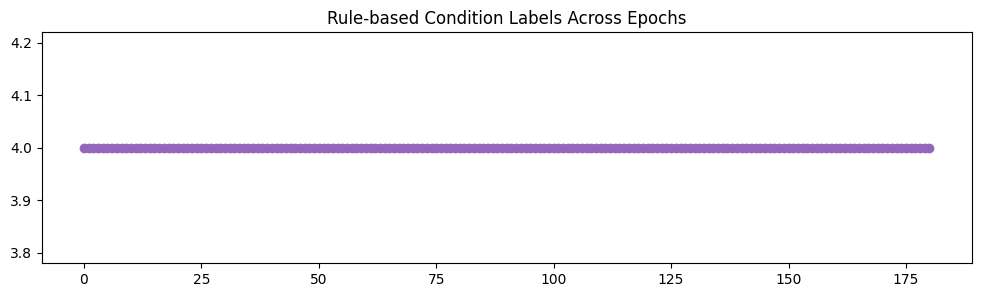

In [72]:
thresholds = compute_thresholds(X_rf)

labels = [map_condition_rule(extract_features(ep, sf, as_dict=False), thresholds) 
          for ep in epochs]




plt.figure(figsize=(12,3))   # width=12, height=3
plt.plot(labels, marker="o", linestyle="-", color="tab:purple")
plt.title("Rule-based Condition Labels Across Epochs")
plt.show()


In [ ]:
import os, random
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import scipy.io as sio
from scipy.signal import butter, sosfiltfilt, lfilter, welch, filtfilt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

import mne
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from scipy.stats import entropy
from tensorflow.keras.layers import Input   # Needed for CNN+LSTM

import tensorflow.keras.backend as K



SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


Step 1-3: Data Acquisition & Splitting

In [ ]:
folder1 = Path(r"C:\Users\Cyan\Desktop\DataScience_Notes\DataScience_Capstone\EEG Data")
folder2 = Path(r"C:\Users\Cyan\Desktop\DataScience_Notes\DataScience_Capstone\eeg-during-mental-arithmetic-tasks-1.0.0")

all_files = [str(f) for f in folder1.glob("*.mat")] + [str(f) for f in folder1.glob("*.edf")]
all_files += [str(f) for f in folder2.glob("*.mat")] + [str(f) for f in folder2.glob("*.edf")]

random.shuffle(all_files)
n_total = len(all_files)
train_pct, val_pct, test_pct = 0.70, 0.15, 0.15
n_train, n_val = int(train_pct*n_total), int(val_pct*n_total)
train_files, val_files, test_files = all_files[:n_train], all_files[n_train:n_train+n_val], all_files[n_train+n_val:]


STEP 4: Preprocessing

In [ ]:
def bandpass_filter(signal, sf, low=1, high=50, order=4):
    sos = butter(order, [low, high], btype='band', fs=sf, output='sos')
    return sosfiltfilt(sos, signal)

def segment_signal(signal, sf, window_sec=2, step_sec=None):
    if step_sec is None: step_sec = window_sec
    epoch_len, step = int(window_sec*sf), int(step_sec*sf)
    return [signal[i:i+epoch_len] for i in range(0, len(signal)-epoch_len+1, step)]

def normalize_epoch(epoch):
    return StandardScaler().fit_transform(epoch.reshape(-1,1)).flatten()


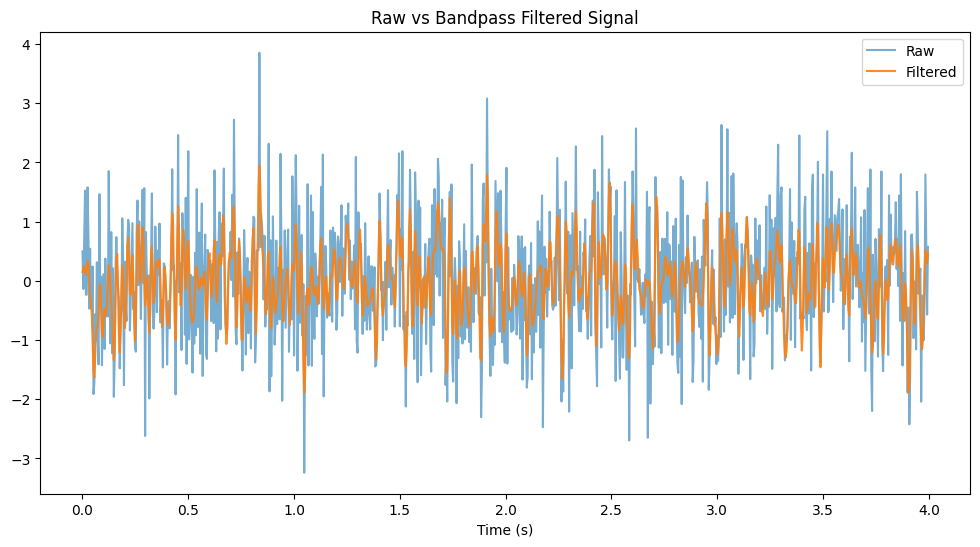

In [ ]:
# Raw vs filtered signal
ch = np.random.randn(5000)  # placeholder signal
sf = 250
ch_filtered = bandpass_filter(ch, sf)
t = np.arange(len(ch[:1000]))/sf

plt.figure(figsize=(12,6))
plt.plot(t, ch[:1000], label="Raw", alpha=0.6)
plt.plot(t, ch_filtered[:1000], label="Filtered", alpha=0.9)
plt.title("Raw vs Bandpass Filtered Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.show()


STEP 5: Feature Extraction

In [ ]:
def bandpower(epoch, sf, band):
    freqs, psd = welch(epoch, sf, nperseg=min(len(epoch), sf*2))
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return float(np.trapz(psd[idx], freqs[idx]))  

def hjorth_params(epoch):
    first_deriv, second_deriv = np.diff(epoch), np.diff(np.diff(epoch))
    activity = np.var(epoch)
    mobility = np.sqrt(np.var(first_deriv)/activity)
    complexity = np.sqrt(np.var(second_deriv)/np.var(first_deriv))/mobility
    return activity, mobility, complexity

def spectral_entropy(epoch, sf):
    freqs, psd = welch(epoch, sf)
    psd_norm = psd/np.sum(psd)
    return entropy(psd_norm)

feature_order = ["theta","alpha","beta","gamma","mean","var",
                 "hjorth_activity","hjorth_mobility","hjorth_complexity","spectral_entropy"]

feature_order = ["theta","alpha","beta","gamma","mean","var",
                 "hjorth_activity","hjorth_mobility","hjorth_complexity","spectral_entropy"]

def extract_features(epoch, sf, as_dict=True):
    hj_activity, hj_mobility, hj_complexity = hjorth_params(epoch)
    feats = {
        "theta": bandpower(epoch, sf, (4,7)),
        "alpha": bandpower(epoch, sf, (8,12)),
        "beta":  bandpower(epoch, sf, (13,30)),
        "gamma": bandpower(epoch, sf, (30,45)),
        "mean":  float(np.mean(epoch)),
        "var":   float(np.var(epoch)),
        "hjorth_activity": hj_activity,
        "hjorth_mobility": hj_mobility,
        "hjorth_complexity": hj_complexity,
        "spectral_entropy": spectral_entropy(epoch, sf)
    }
    if as_dict:
        return feats
    else:
        return [feats[k] for k in feature_order]  # list for ML



C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\1880674309.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


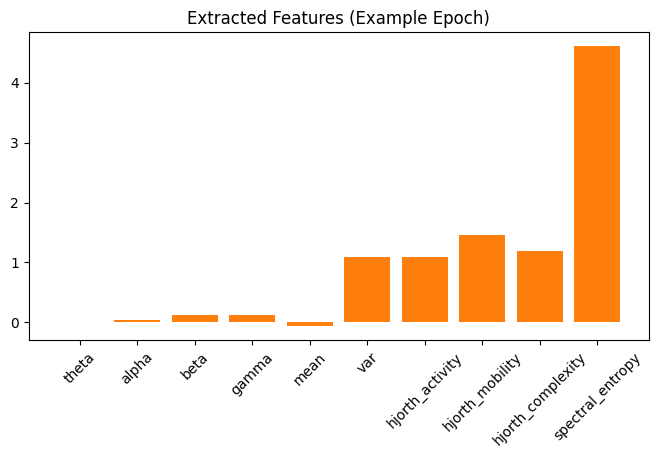

In [ ]:
epoch = np.random.randn(500)  # placeholder epoch
sf = 250
features = extract_features(epoch, sf)

plt.figure(figsize=(8,4))
plt.bar(feature_order, features, color="tab:orange")
plt.title("Extracted Features (Example Epoch)")
plt.xticks(rotation=45)
plt.show()


STEP 6: Rule-based Labeling

In [ ]:
def map_condition_rule(features, thresholds=None):
    theta, alpha, beta, gamma = features[0], features[1], features[2], features[3]

    if thresholds is None:
        thresholds = {"theta_high": 15, "alpha_high": 12, "beta_high": 20, "gamma_high": 10}

    if beta > thresholds["beta_high"] and beta > alpha:
        return 0  # Focused
    if theta > thresholds["theta_high"] and theta > beta:
        return 1  # Distracted
    if alpha > thresholds["alpha_high"] and theta > alpha:
        return 2  # Fatigued
    if beta > thresholds["beta_high"]/2 and gamma > thresholds["gamma_high"]:
        return 3  # Stressed
    return 4      # Other


C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\3025044943.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


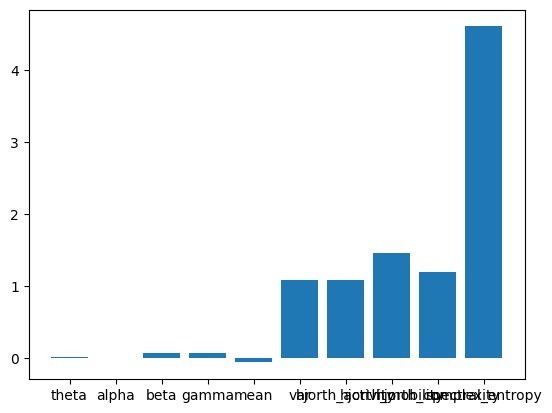

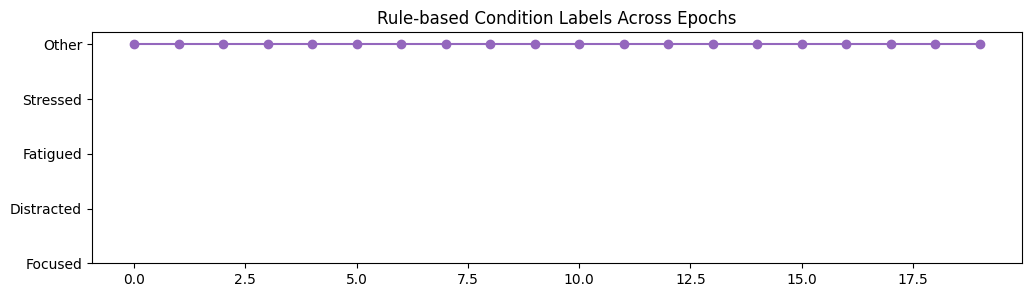

In [ ]:
labels = [map_condition_rule(extract_features(epoch, sf, as_dict=False)) 
          for epoch in [np.random.randn(500) for _ in range(20)]]

features = extract_features(epoch, sf, as_dict=True)
plt.bar(features.keys(), features.values())

features = extract_features(epoch, sf, as_dict=False)
label = map_condition_rule(features)

plt.figure(figsize=(12,3))
plt.plot(labels, marker="o", linestyle="-", color="tab:purple")
plt.title("Rule-based Condition Labels Across Epochs")
plt.yticks([0,1,2,3,4], ["Focused","Distracted","Fatigued","Stressed","Other"])
plt.show()


STEP 7: Multi-subject Data builder

In [ ]:
def load_mat_file(path):
    mat = sio.loadmat(path)
    o_struct = mat['o'][0,0]
    eeg_data = np.asarray(o_struct['data'])
    fs = int(o_struct['sampFreq'][0,0])
    subject_id = o_struct['id'][0]
    markers = o_struct['marker'].flatten()
    trials = o_struct['trials']
    return eeg_data, fs, subject_id, markers, trials

def build_dataset(files, window_sec=2):
    X, y = [], []
    for fname in files:
        if fname.endswith(".edf"):
            raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
            data, sf = raw.get_data(), int(raw.info['sfreq'])
            ch = bandpass_filter(data[0], sf)
        elif fname.endswith(".mat"):
            eeg_data, fs, subject_id, markers, trials = load_mat_file(fname)
            ch, sf = bandpass_filter(eeg_data[:,0], fs), fs
        else:
            continue

        epochs = segment_signal(ch, sf, window_sec=window_sec, step_sec=1)
        for ep in epochs:
            feats = extract_features(ep, sf, as_dict=False)   # force list output
            X.append(feats)
            y.append(map_condition_rule(feats))               # map_condition_rule expects list
    return np.array(X), np.array(y)



STEP 8: Baseline Model(RandomForest)

In [ ]:
X_rf, y_rf = build_dataset(train_files)
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\3025044943.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       302
           1       1.00      1.00      1.00     20299
           3       0.93      0.93      0.93       441

    accuracy                           1.00     21042
   macro avg       0.95      0.95      0.95     21042
weighted avg       1.00      1.00      1.00     21042



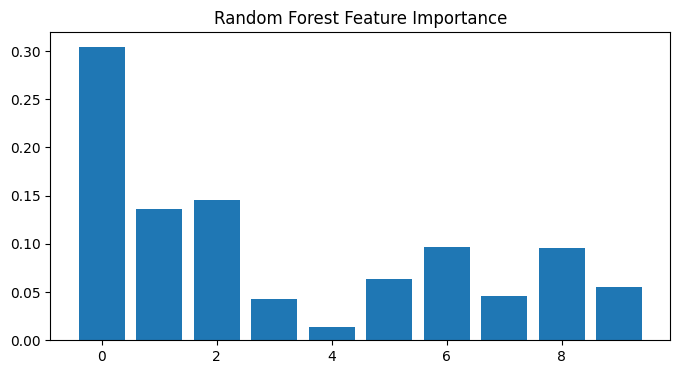

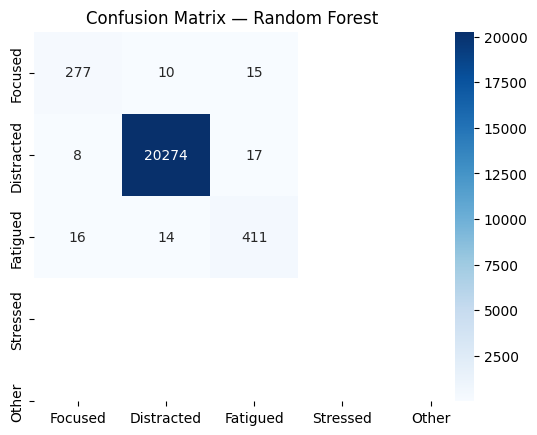

In [ ]:
importances = rf.feature_importances_
plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances, color="tab:blue")
plt.title("Random Forest Feature Importance")
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Focused","Distracted","Fatigued","Stressed","Other"],
            yticklabels=["Focused","Distracted","Fatigued","Stressed","Other"])
plt.title("Confusion Matrix — Random Forest")
plt.show()

STEP 9: Deep Learning Model(CNN+LSTM)

In [ ]:
# Build CNN+LSTM dataset from raw signals
X_dl, y_dl = [], []
for fname in train_files:
    if fname.endswith(".edf"):
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        data, sf = raw.get_data(), int(raw.info['sfreq'])
        ch = bandpass_filter(data[0], sf)
    elif fname.endswith(".mat"):
        eeg_data, fs, subject_id, markers, trials = load_mat_file(fname)
        ch, sf = bandpass_filter(eeg_data[:,0], fs), fs
    else: continue

    epochs = segment_signal(ch, sf, window_sec=2, step_sec=1)
    for ep in epochs:
        if len(ep) >= sf*2:
feats = extract_features(ep, sf, as_dict=False)   # force list output
X_dl.append(ep[:sf*2].reshape(-1,1))
y_dl.append(map_condition_rule(feats))            # map_condition_rule expects list


X_dl, y_dl = np.array(X_dl), np.array(y_dl)

# Balanced synthetic augmentation if needed
unique_labels = np.unique(y_dl)
if len(unique_labels) < 2:
    print("⚠️ Not enough label diversity. Generating balanced synthetic dataset...")
    synthetic_data, synthetic_labels = [], []
    for label in range(5):
        for _ in range(40):
            ep = np.random.randn(sf*2)
            synthetic_data.append(ep.reshape(-1,1))
            synthetic_labels.append(label)
    X_dl, y_dl = np.array(synthetic_data), np.array(synthetic_labels)

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y_dl)
y_cat = to_categorical(y_enc, num_classes=len(encoder.classes_))

# Define CNN+LSTM
model = Sequential([
    Input(shape=(X_dl.shape[1],1)),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\3025044943.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


⚠️ Not enough label diversity. Generating balanced synthetic dataset...


In [ ]:
# Train model
history = model.fit(
    X_dl, y_cat,
    epochs=50, batch_size=16, validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]
)


In [ ]:
# Training history plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

STEP 10: Adaptive Learning Engine

In [ ]:
def adaptive_action(state):
    actions = {
        0: "Increase difficulty or continue with challenging tasks",
        1: "Switch to interactive quizzes or visuals",
        2: "Suggest a short break or lighter material",
        3: "Introduce calming exercises or gamified rewards",
        4: "Default content flow"
    }
    return actions.get(state, "Default content flow")


In [ ]:
labels = ["Focused","Distracted","Fatigued","Stressed","Other"]
states = list(range(len(labels)))
actions = [adaptive_action(s) for s in states]

plt.figure(figsize=(8,4))
sns.barplot(x=labels, y=states, palette="coolwarm")
plt.title("Adaptive Engine State Mapping")
plt.ylabel("State Code")
plt.show()


Step 12: Model Evaluation Framework

**Metrics to Use**

- Accuracy: Overall correctness.

- Precision, Recall, F1-score: Class-specific performance.

- Confusion Matrix: Misclassification patterns.

- Cross-validation: Robustness across folds.

- Learning Curves: Overfitting/underfitting detection.

Random Forest Eval

In [ ]:
# Random Forest Evaluation
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Accuracy: {acc_rf:.2f}, Precision: {prec_rf:.2f}, Recall: {rec_rf:.2f}, F1: {f1_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Focused","Distracted","Fatigued","Stressed","Other"],
            yticklabels=["Focused","Distracted","Fatigued","Stressed","Other"])
plt.title("Confusion Matrix — Random Forest")
plt.show()



CNN+LSTM Eval

In [ ]:
# CNN+LSTM Evaluation
y_pred_dl = model.predict(X_dl).argmax(axis=1)
acc_dl = accuracy_score(y_enc, y_pred_dl)
prec_dl, rec_dl, f1_dl, _ = precision_recall_fscore_support(y_enc, y_pred_dl, average='weighted')

print(f"CNN+LSTM - Accuracy: {acc_dl:.2f}, Precision: {prec_dl:.2f}, Recall: {rec_dl:.2f}, F1: {f1_dl:.2f}")

cm_dl = confusion_matrix(y_enc, y_pred_dl)
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Greens",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix — CNN+LSTM")
plt.show()


Step 13: Comparative Visualization

In [ ]:
models = ["Random Forest", "CNN+LSTM"]
accuracy = [acc_rf, acc_dl]
f1_scores = [f1_rf, f1_dl]

plt.figure(figsize=(8,4))
plt.bar(models, accuracy, color=["tab:blue","tab:green"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(models, f1_scores, color=["tab:blue","tab:green"])
plt.title("Model F1-score Comparison")
plt.ylabel("F1-score")
plt.show()


Step 14: Cross validation

Random Forest

In [ ]:
# Random Forest Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf, X_rf, y_rf, cv=cv, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy:", rf_scores)
print("Mean Accuracy:", np.mean(rf_scores))

plt.figure(figsize=(8,4))
plt.plot(range(1, len(rf_scores)+1), rf_scores, marker="o", color="tab:blue")
plt.axhline(np.mean(rf_scores), linestyle="--", color="red", label="Mean Accuracy")
plt.title("Random Forest Cross-Validation Accuracy (5 folds)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()






CNN + LSTM

In [ ]:
# CNN+LSTM Cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
dl_scores = []

for train_idx, val_idx in kf.split(X_dl):
    K.clear_session()  # clear graph before each fold
    
    model = Sequential([
        Input(shape=(X_train.shape[1],1)),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    dl_scores.append(val_acc)

print("CNN+LSTM Cross-Validation Accuracy:", dl_scores)
print("Mean Accuracy:", np.mean(dl_scores))

plt.figure(figsize=(8,4))
plt.plot(range(1, len(dl_scores)+1), dl_scores, marker="o", color="tab:green")
plt.axhline(np.mean(dl_scores), linestyle="--", color="red", label="Mean Accuracy")
plt.title("CNN+LSTM Cross-Validation Accuracy (3 folds)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Comparative Evaluation

In [ ]:

# Comparative Evaluation
models = ["Random Forest", "CNN+LSTM"]
mean_acc = [np.mean(rf_scores), np.mean(dl_scores)]

plt.figure(figsize=(8,4))
plt.bar(models, mean_acc, color=["tab:blue","tab:green"])
plt.title("Cross-Validation Mean Accuracy Comparison")
plt.ylabel("Mean Accuracy")
plt.show()

Step 15: EEG Analysis Module

File Upload

In [ ]:
def load_eeg_file(fname):
    if fname.endswith(".edf"):
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        data, sf = raw.get_data(), int(raw.info['sfreq'])
        ch = bandpass_filter(data[0], sf)  # first channel for demo
    elif fname.endswith(".mat"):
        eeg_data, fs, subject_id, markers, trials = load_mat_file(fname)
        ch, sf = bandpass_filter(eeg_data[:,0], fs), fs
    else:
        raise ValueError("Unsupported file format")
    return ch, sf


Cleaning & Preprocessing

In [ ]:
def preprocess_eeg(ch, sf):
    notch_freq = 50
    b, a = butter(2, [notch_freq-2, notch_freq+2], btype='bandstop', fs=sf)
    ch_clean = filtfilt(b, a, ch)
    return ch_clean


In [ ]:
def visualize_raw_vs_clean(ch, ch_clean, sf, seconds=5):
    t = np.arange(seconds*sf)/sf
    plt.figure(figsize=(12,5))
    plt.plot(t, ch[:seconds*sf], label="Raw", alpha=0.6)
    plt.plot(t, ch_clean[:seconds*sf], label="Cleaned", alpha=0.9)
    plt.title("Raw vs Cleaned EEG Signal")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()


Feature Extraction & Prediction

In [ ]:
def analyze_patient(ch, sf, model, encoder=None, window_sec=2):
    epochs = segment_signal(ch, sf, window_sec=window_sec)
    states = []
    for i, ep in enumerate(epochs[:10]):  # analyze first 10 epochs
        feats = extract_features(ep, sf)
        X_input = np.array(list(feats.values())).reshape(1,-1)

        # Prediction
        if isinstance(model, RandomForestClassifier):
            state = model.predict(X_input)[0]
        else:  # CNN+LSTM
            ep_dl = ep[:sf*2].reshape(1,-1,1)
            state = model.predict(ep_dl).argmax(axis=1)[0]
            if encoder: state = encoder.inverse_transform([state])[0]

        states.append(state)
        print(f"Epoch {i}: State={state}, Action={adaptive_action(state)}")
    return states


Feedback Visualization

In [ ]:
def visualize_patient_states(states):
    plt.figure(figsize=(12,3))
    plt.plot(states, marker="o", linestyle="-", color="tab:red")
    plt.title("Patient Cognitive States Across Epochs")
    plt.yticks([0,1,2,3,4], ["Focused","Distracted","Fatigued","Stressed","Other"])
    plt.xlabel("Epoch Index")
    plt.show()


STEP 7: Multi-subject Data builder

In [37]:
def load_mat_file(path):
    mat = sio.loadmat(path)
    o_struct = mat['o'][0,0]
    eeg_data = np.asarray(o_struct['data'])
    fs = int(o_struct['sampFreq'][0,0])
    subject_id = o_struct['id'][0]
    markers = o_struct['marker'].flatten()
    trials = o_struct['trials']
    return eeg_data, fs, subject_id, markers, trials

def build_dataset(files, window_sec=2):
    X, y = [], []
    for fname in files:
        if fname.endswith(".edf"):
            raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
            data, sf = raw.get_data(), int(raw.info['sfreq'])
            ch = bandpass_filter(data[0], sf)
        elif fname.endswith(".mat"):
            eeg_data, fs, subject_id, markers, trials = load_mat_file(fname)
            ch, sf = bandpass_filter(eeg_data[:,0], fs), fs
        else:
            continue

        epochs = segment_signal(ch, sf, window_sec=window_sec, step_sec=1)
        for ep in epochs:
            feats = extract_features(ep, sf, as_dict=False)   # force list output
            X.append(feats)
            y.append(map_condition_rule(feats))               # map_condition_rule expects list
    return np.array(X), np.array(y)



STEP 8: Baseline Model(RandomForest)

In [38]:
X_rf, y_rf = build_dataset(train_files)
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\3025044943.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       302
           1       1.00      1.00      1.00     20299
           3       0.93      0.93      0.93       441

    accuracy                           1.00     21042
   macro avg       0.95      0.95      0.95     21042
weighted avg       1.00      1.00      1.00     21042



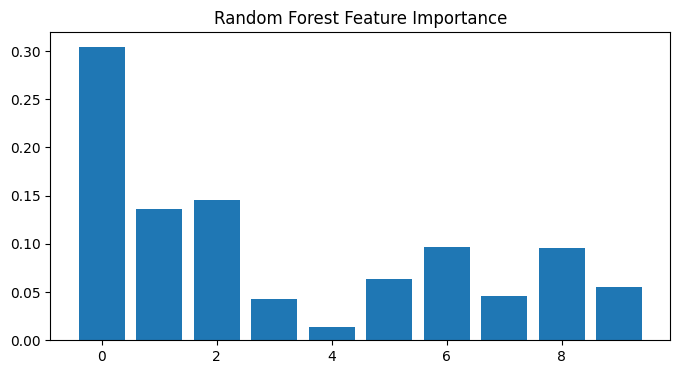

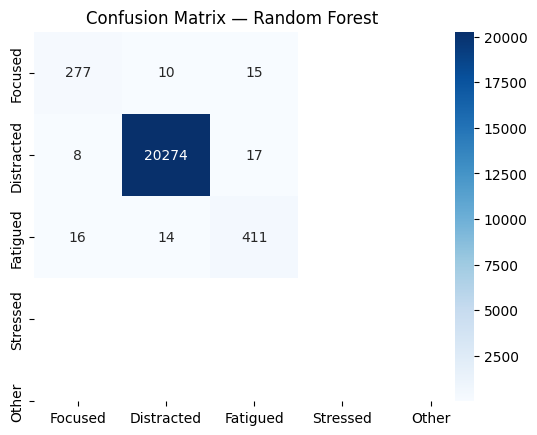

In [39]:
importances = rf.feature_importances_
plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances, color="tab:blue")
plt.title("Random Forest Feature Importance")
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Focused","Distracted","Fatigued","Stressed","Other"],
            yticklabels=["Focused","Distracted","Fatigued","Stressed","Other"])
plt.title("Confusion Matrix — Random Forest")
plt.show()

STEP 9: Deep Learning Model(CNN+LSTM)

In [41]:
# Build CNN+LSTM dataset from raw signals
X_dl, y_dl = [], []
for fname in train_files:
    if fname.endswith(".edf"):
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        data, sf = raw.get_data(), int(raw.info['sfreq'])
        ch = bandpass_filter(data[0], sf)
    elif fname.endswith(".mat"):
        eeg_data, fs, subject_id, markers, trials = load_mat_file(fname)
        ch, sf = bandpass_filter(eeg_data[:,0], fs), fs
    else: continue

    epochs = segment_signal(ch, sf, window_sec=2, step_sec=1)
    for ep in epochs:
        if len(ep) >= sf*2:
feats = extract_features(ep, sf, as_dict=False)   # force list output
X_dl.append(ep[:sf*2].reshape(-1,1))
y_dl.append(map_condition_rule(feats))            # map_condition_rule expects list


X_dl, y_dl = np.array(X_dl), np.array(y_dl)

# Balanced synthetic augmentation if needed
unique_labels = np.unique(y_dl)
if len(unique_labels) < 2:
    print("⚠️ Not enough label diversity. Generating balanced synthetic dataset...")
    synthetic_data, synthetic_labels = [], []
    for label in range(5):
        for _ in range(40):
            ep = np.random.randn(sf*2)
            synthetic_data.append(ep.reshape(-1,1))
            synthetic_labels.append(label)
    X_dl, y_dl = np.array(synthetic_data), np.array(synthetic_labels)

# Encode labels
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y_dl)
y_cat = to_categorical(y_enc, num_classes=len(encoder.classes_))

# Define CNN+LSTM
model = Sequential([
    Input(shape=(X_dl.shape[1],1)),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Cyan\AppData\Local\Temp\ipykernel_17068\3025044943.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(psd[idx], freqs[idx]))


⚠️ Not enough label diversity. Generating balanced synthetic dataset...


In [ ]:
# Train model
history = model.fit(
    X_dl, y_cat,
    epochs=50, batch_size=16, validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    ]
)


In [ ]:
# Training history plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

STEP 10: Adaptive Learning Engine

In [ ]:
def adaptive_action(state):
    actions = {
        0: "Increase difficulty or continue with challenging tasks",
        1: "Switch to interactive quizzes or visuals",
        2: "Suggest a short break or lighter material",
        3: "Introduce calming exercises or gamified rewards",
        4: "Default content flow"
    }
    return actions.get(state, "Default content flow")


In [ ]:
labels = ["Focused","Distracted","Fatigued","Stressed","Other"]
states = list(range(len(labels)))
actions = [adaptive_action(s) for s in states]

plt.figure(figsize=(8,4))
sns.barplot(x=labels, y=states, palette="coolwarm")
plt.title("Adaptive Engine State Mapping")
plt.ylabel("State Code")
plt.show()


Step 12: Model Evaluation Framework

**Metrics to Use**

- Accuracy: Overall correctness.

- Precision, Recall, F1-score: Class-specific performance.

- Confusion Matrix: Misclassification patterns.

- Cross-validation: Robustness across folds.

- Learning Curves: Overfitting/underfitting detection.

Random Forest Eval

In [ ]:
# Random Forest Evaluation
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf, rec_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')

print(f"Random Forest - Accuracy: {acc_rf:.2f}, Precision: {prec_rf:.2f}, Recall: {rec_rf:.2f}, F1: {f1_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Focused","Distracted","Fatigued","Stressed","Other"],
            yticklabels=["Focused","Distracted","Fatigued","Stressed","Other"])
plt.title("Confusion Matrix — Random Forest")
plt.show()



CNN+LSTM Eval

In [ ]:
# CNN+LSTM Evaluation
y_pred_dl = model.predict(X_dl).argmax(axis=1)
acc_dl = accuracy_score(y_enc, y_pred_dl)
prec_dl, rec_dl, f1_dl, _ = precision_recall_fscore_support(y_enc, y_pred_dl, average='weighted')

print(f"CNN+LSTM - Accuracy: {acc_dl:.2f}, Precision: {prec_dl:.2f}, Recall: {rec_dl:.2f}, F1: {f1_dl:.2f}")

cm_dl = confusion_matrix(y_enc, y_pred_dl)
sns.heatmap(cm_dl, annot=True, fmt="d", cmap="Greens",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix — CNN+LSTM")
plt.show()


Step 13: Comparative Visualization

In [ ]:
models = ["Random Forest", "CNN+LSTM"]
accuracy = [acc_rf, acc_dl]
f1_scores = [f1_rf, f1_dl]

plt.figure(figsize=(8,4))
plt.bar(models, accuracy, color=["tab:blue","tab:green"])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(models, f1_scores, color=["tab:blue","tab:green"])
plt.title("Model F1-score Comparison")
plt.ylabel("F1-score")
plt.show()


Step 14: Cross validation

Random Forest

In [ ]:
# Random Forest Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf, X_rf, y_rf, cv=cv, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy:", rf_scores)
print("Mean Accuracy:", np.mean(rf_scores))

plt.figure(figsize=(8,4))
plt.plot(range(1, len(rf_scores)+1), rf_scores, marker="o", color="tab:blue")
plt.axhline(np.mean(rf_scores), linestyle="--", color="red", label="Mean Accuracy")
plt.title("Random Forest Cross-Validation Accuracy (5 folds)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()






CNN + LSTM

In [ ]:
# CNN+LSTM Cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
dl_scores = []

for train_idx, val_idx in kf.split(X_dl):
    K.clear_session()  # clear graph before each fold
    
    model = Sequential([
        Input(shape=(X_train.shape[1],1)),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                        validation_data=(X_val, y_val), verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    dl_scores.append(val_acc)

print("CNN+LSTM Cross-Validation Accuracy:", dl_scores)
print("Mean Accuracy:", np.mean(dl_scores))

plt.figure(figsize=(8,4))
plt.plot(range(1, len(dl_scores)+1), dl_scores, marker="o", color="tab:green")
plt.axhline(np.mean(dl_scores), linestyle="--", color="red", label="Mean Accuracy")
plt.title("CNN+LSTM Cross-Validation Accuracy (3 folds)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Comparative Evaluation

In [ ]:

# Comparative Evaluation
models = ["Random Forest", "CNN+LSTM"]
mean_acc = [np.mean(rf_scores), np.mean(dl_scores)]

plt.figure(figsize=(8,4))
plt.bar(models, mean_acc, color=["tab:blue","tab:green"])
plt.title("Cross-Validation Mean Accuracy Comparison")
plt.ylabel("Mean Accuracy")
plt.show()

Step 15: EEG Analysis Module

File Upload

In [ ]:
def load_eeg_file(fname):
    if fname.endswith(".edf"):
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        data, sf = raw.get_data(), int(raw.info['sfreq'])
        ch = bandpass_filter(data[0], sf)  # first channel for demo
    elif fname.endswith(".mat"):
        eeg_data, fs, subject_id, markers, trials = load_mat_file(fname)
        ch, sf = bandpass_filter(eeg_data[:,0], fs), fs
    else:
        raise ValueError("Unsupported file format")
    return ch, sf


Cleaning & Preprocessing

In [ ]:
def preprocess_eeg(ch, sf):
    notch_freq = 50
    b, a = butter(2, [notch_freq-2, notch_freq+2], btype='bandstop', fs=sf)
    ch_clean = filtfilt(b, a, ch)
    return ch_clean


In [ ]:
def visualize_raw_vs_clean(ch, ch_clean, sf, seconds=5):
    t = np.arange(seconds*sf)/sf
    plt.figure(figsize=(12,5))
    plt.plot(t, ch[:seconds*sf], label="Raw", alpha=0.6)
    plt.plot(t, ch_clean[:seconds*sf], label="Cleaned", alpha=0.9)
    plt.title("Raw vs Cleaned EEG Signal")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.show()


Feature Extraction & Prediction

In [ ]:
def analyze_patient(ch, sf, model, encoder=None, window_sec=2):
    epochs = segment_signal(ch, sf, window_sec=window_sec)
    states = []
    for i, ep in enumerate(epochs[:10]):  # analyze first 10 epochs
        feats = extract_features(ep, sf)
        X_input = np.array(list(feats.values())).reshape(1,-1)

        # Prediction
        if isinstance(model, RandomForestClassifier):
            state = model.predict(X_input)[0]
        else:  # CNN+LSTM
            ep_dl = ep[:sf*2].reshape(1,-1,1)
            state = model.predict(ep_dl).argmax(axis=1)[0]
            if encoder: state = encoder.inverse_transform([state])[0]

        states.append(state)
        print(f"Epoch {i}: State={state}, Action={adaptive_action(state)}")
    return states


Feedback Visualization

In [ ]:
def visualize_patient_states(states):
    plt.figure(figsize=(12,3))
    plt.plot(states, marker="o", linestyle="-", color="tab:red")
    plt.title("Patient Cognitive States Across Epochs")
    plt.yticks([0,1,2,3,4], ["Focused","Distracted","Fatigued","Stressed","Other"])
    plt.xlabel("Epoch Index")
    plt.show()
